In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

HYPERPARAMETRERS AND DIRECTORIES


In [ ]:
train_dir = "/content/drive/MyDrive/archive (1)/train"
test_dir = "/content/drive/MyDrive/archive (1)/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['goal','happy', 'loss']
CLASS_LABELS_EMOJIS = ["😃" , "😊" , "😔" ]

DATA LOADING AND PRE-PROCESSING

In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 12022 images belonging to 3 classes.
Found 3004 images belonging to 3 classes.
Found 7227 images belonging to 3 classes.


Images with different emotions

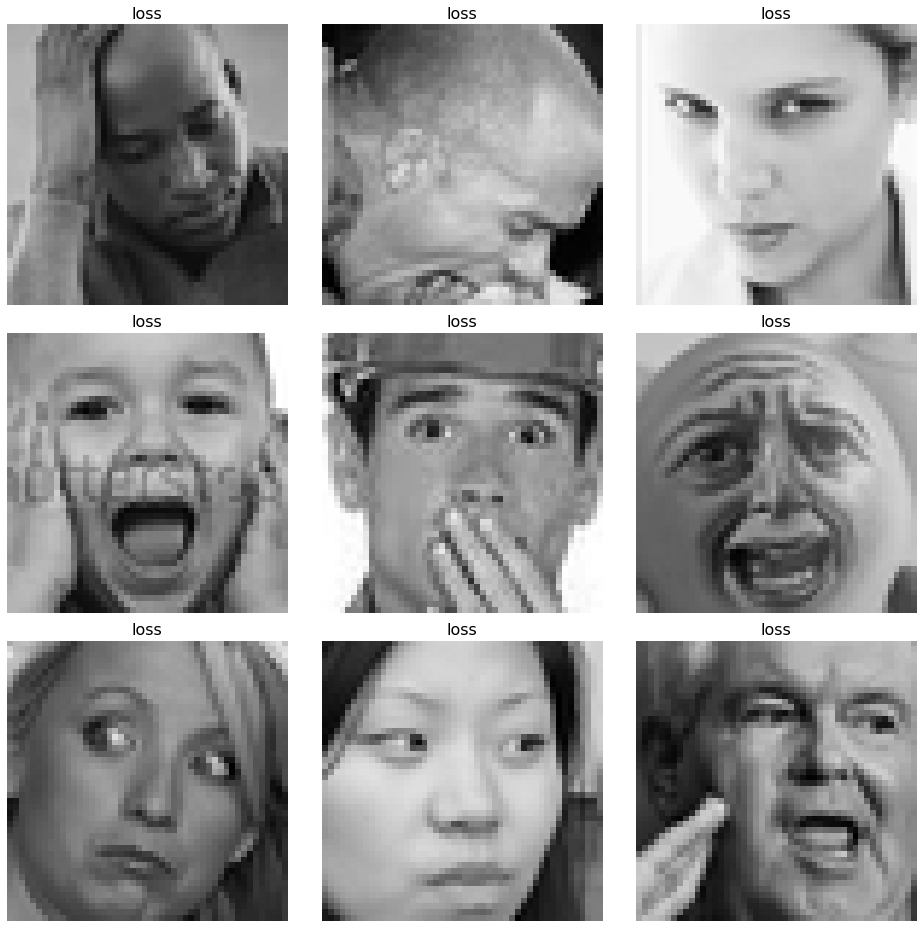

In [ ]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

Data distribution (count) among differnt emotions

In [ ]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

DenseNet169 Transfer Learning

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

Summary of model

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d_2   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               426240    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                           

Training and Fine-Tuning

Training model with freezed layers of DenseNer169

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
188/188 [==============================] - 221s 360ms/step - loss: 11.2740 - accuracy: 0.8352 - val_loss: 12.0691 - val_accuracy: 0.8119
Epoch 2/30
188/188 [==============================] - 37s 198ms/step - loss: 5.3714 - accuracy: 0.9060 - val_loss: 3.9172 - val_accuracy: 0.8136
Epoch 3/30
188/188 [==============================] - 37s 195ms/step - loss: 2.6345 - accuracy: 0.9212 - val_loss: 2.1184 - val_accuracy: 0.8129
Epoch 4/30
188/188 [==============================] - 38s 200ms/step - loss: 1.3731 - accuracy: 0.9183 - val_loss: 1.4415 - val_accuracy: 0.8412
Epoch 5/30
188/188 [==============================] - 37s 199ms/step - loss: 0.7508 - accuracy: 0.9309 - val_loss: 0.6680 - val_accuracy: 0.8758
Epoch 6/30
188/188 [==============================] - 37s 196ms/step - loss: 0.4389 - accuracy: 0.9399 - val_loss: 0.4184 - val_accuracy: 0.9174
Epoch 7/30
188/188 [==============================] - 37s 194ms/step - loss: 0.2911 - accuracy: 0.9439 - val_loss: 0.3003 - val

Fine Tuning

In [ ]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
188/188 [==============================] - 50s 201ms/step - loss: 0.1088 - accuracy: 0.9679 - val_loss: 0.1991 - val_accuracy: 0.9358
Epoch 2/20
188/188 [==============================] - 36s 191ms/step - loss: 0.1002 - accuracy: 0.9720 - val_loss: 0.1982 - val_accuracy: 0.9368
Epoch 3/20
188/188 [==============================] - 37s 199ms/step - loss: 0.1005 - accuracy: 0.9716 - val_loss: 0.1972 - val_accuracy: 0.9384
Epoch 4/20
188/188 [==============================] - 36s 191ms/step - loss: 0.0924 - accuracy: 0.9756 - val_loss: 0.1988 - val_accuracy: 0.9391
Epoch 5/20
188/188 [==============================] - 36s 190ms/step - loss: 0.0885 - accuracy: 0.9750 - val_loss: 0.1996 - val_accuracy: 0.9387
Epoch 6/20
188/188 [==============================] - 37s 195ms/step - loss: 0.0909 - accuracy: 0.9753 - val_loss: 0.2003 - val_accuracy: 0.9384
Epoch 7/20
188/188 [==============================] - 36s 193ms/step - loss: 0.0872 - accuracy: 0.9771 - val_loss: 0.2007 - val_ac

Training plots

In [ ]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

Visualizing Results

Model Evaluation

In [ ]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 13s 95ms/step


Confusion Matrix

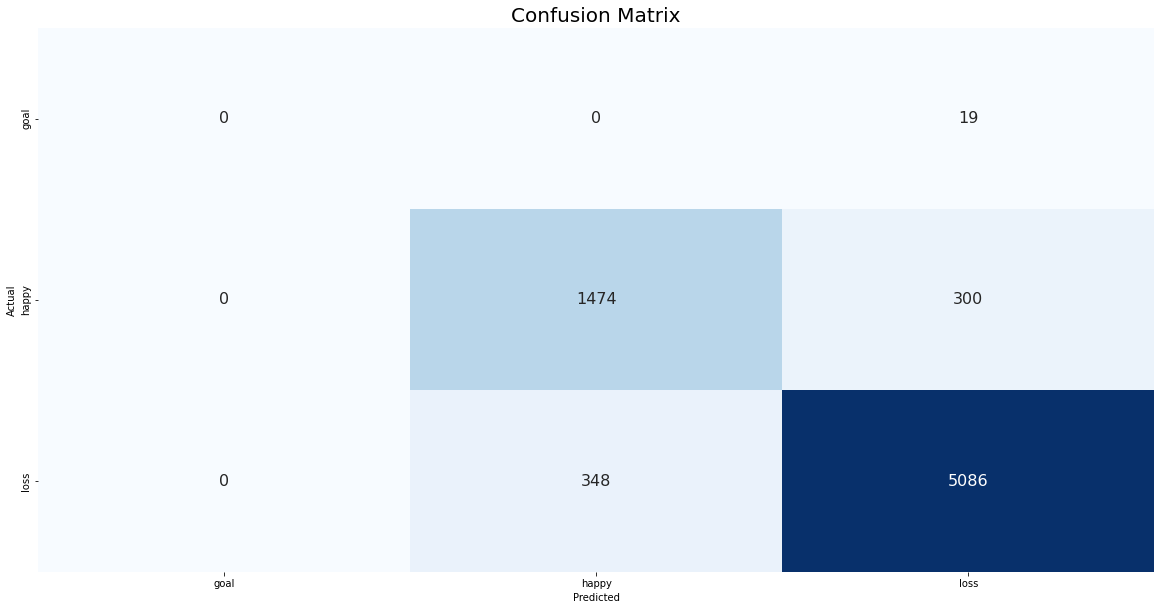

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

Classification Report

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.81      0.83      0.82      1774
           2       0.94      0.94      0.94      5434

    accuracy                           0.91      7227
   macro avg       0.58      0.59      0.59      7227
weighted avg       0.91      0.91      0.91      7227



Multiclass AUC Curve

ROC AUC score: 0.9799577409553129


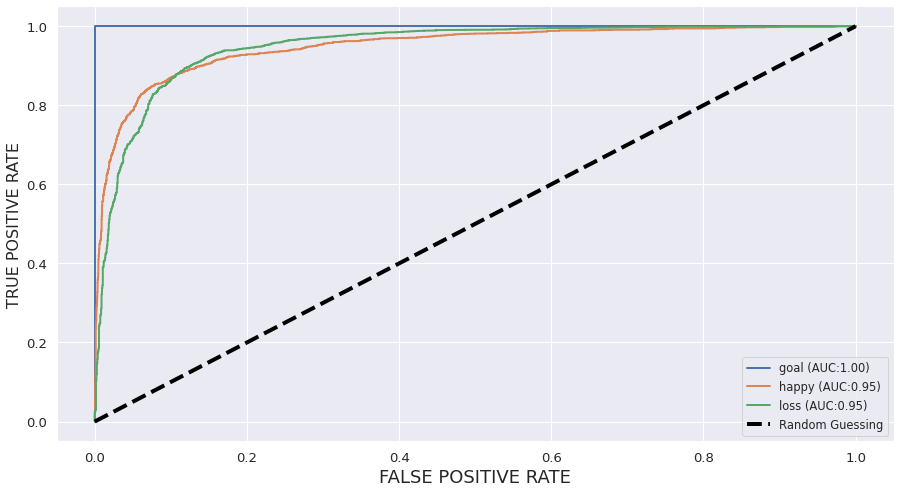

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.965638741995841


2.METHOD

In [ ]:
!pip install deepface
from deepface import DeepFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
     |████████████████████████████████| 2.3 MB 68.4 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=8c09fac38be0038bc7d47b4c2f17f826ede1b5ec36ea689b15fa13db0e06e495
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire
Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
video_path = "/content/drive/MyDrive/archive (1)/train"

In [ ]:
import cv2

In [ ]:
face_model =cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")

In [ ]:
frame_list = []

In [ ]:
capture = cv2.VideoCapture(video_path)

In [ ]:
from google.colab.patches import cv2_imshow

In [80]:

for i in range(5000) :
   _, frame = capture.read()
   face = face_model.detectMultiScale(cv2.imread(frame, cv2.COLOR_BGR2GRAY),1.1,5)
   
   for x, y, width, height in face:

    emotion = DeepFace.analyze(frame,actions=["emotion"])
     
    cv2.putText(frame,str(emotion["dominant_emotion"]),
                 (x, y + height),cv2.FONT_HERSHEY_COMPLEX,
                 0.9,
                 (255,255,0),2)
    cv2.rectangle(frame, (x,y),(x+ width, y + height),(0,255,0),3)
     
    frame_list.append(frame)

    height, width, colors = frame.shape
    size = (width ,height)
               

In [81]:
output_path = "/content/drive/MyDrive/archive (1)/Emotions.avi"

output= cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*"DIVX"),10,(640,480))

for frame in range(len(frame_list)):
    output.write(frame_list[frame])


output.release()


3.METHOD

In [105]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array, load_img
from keras.losses import categorical_crossentropy

In [100]:
imgs_path = '/content/drive/MyDrive/archive (1)/train'
imgs_model_width, imgs_model_height = 224, 224

In [101]:
# pre trained model 

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=3 , activation='softmax' )(x)

# custom model.
model = Model(base_model.input, x)
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

In [102]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/archive (1)/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 15026 images belonging to 3 classes.


{'goal': 0, 'happy': 1, 'loss': 2}

In [103]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/archive (1)/test", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 7227 images belonging to 3 classes.


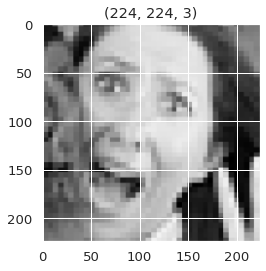

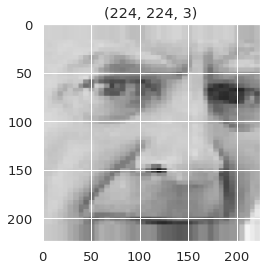

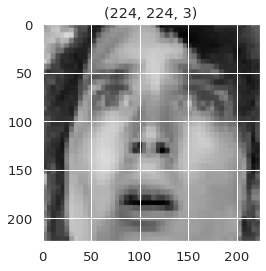

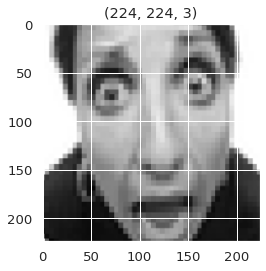

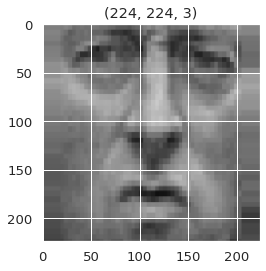

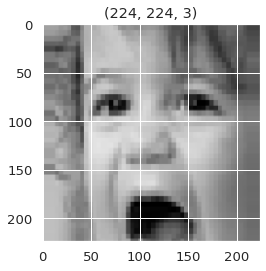

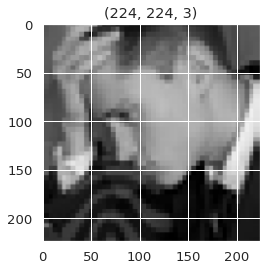

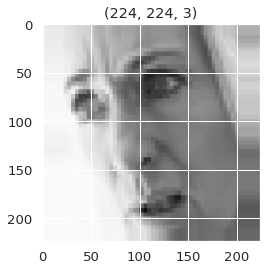

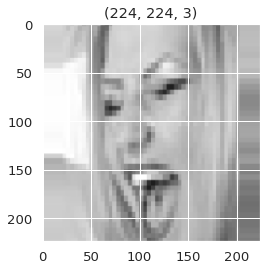

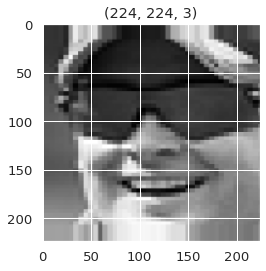

In [104]:
# the images in the training data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# plot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# plot the images 
plotImages(t_img, label)

In [106]:
#early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# call back in a list 
call_back = [es, mc]
print(str(es))

In [107]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 4.0390 - accuracy: 0.7125
Epoch 1: val_accuracy improved from -inf to 0.74219, saving model to best_model.h5
10/10 [==============================] - 8s 489ms/step - loss: 4.0390 - accuracy: 0.7125 - val_loss: 5.2726 - val_accuracy: 0.7422
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 3.0917 - accuracy: 0.7344
Epoch 2: val_accuracy improved from 0.74219 to 0.79688, saving model to best_model.h5
10/10 [==============================] - 5s 458ms/step - loss: 3.0917 - accuracy: 0.7344 - val_loss: 1.9091 - val_accuracy: 0.7969
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 2.4963 - accuracy: 0.7563
Epoch 3: val_accuracy improved from 0.79688 to 0.83594, saving model to best_model.h5
10/10 [==============================] - 5s 459ms/step - loss: 2.4963 - accuracy: 0.7563 - val_loss: 2.1469 - val_accuracy: 0.8359
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.

In [110]:
# o/p values 
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
op

{0: 'goal', 1: 'happy', 2: 'loss'}

1/1 [==============================] - 0s 18ms/step
 the image is of happy


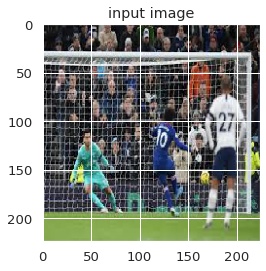

In [112]:
#Prediction
path = "/content/drive/MyDrive/train_data/train_data/images/val/9.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()